In [1]:
import sys
print(sys.executable)
#should be AI project


C:\Users\Johanna\anaconda3\envs\AI_project\python.exe


In [19]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   - -------------------------------------- 2.6/56.8 MB 12.5 MB/s eta 0:00:05
   --- ------------------------------------ 5.2/56.8 MB 12.7 MB/s eta 0:00:05
   ----- ---------------------------------- 8.1/56.8 MB 13.2 MB/s eta 0:00:04
   -------- ------------------------------- 11.5/56.8 MB 13.9 MB/s eta 0:00:04
   ---------- ----------------------------- 15.2/56.8 MB 14.5 MB/s eta 0:00:03
   ------------- -------------------------- 18.6/56.8 MB 14.9 MB/s eta 0:00:03
   --------------- ------------------------ 21.5/56.8 MB 14.8 MB/s eta 0:00:03
   ----------------- ---------------------- 24.9/56.8 MB 15.0 MB/s eta 0:00:03
   -------------------- ------------------- 28.6/56.8 MB 15.2 MB/s eta 0:00:02
   ---------------------- ----------------- 32.2/56.8 MB 15.4 MB/s eta 0:00:02
   ------------------------- -------------- 35.7/56.8 MB 15.5 MB/s eta 0:

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from functools import reduce
from datetime import time
from xgboost import XGBRegressor


In [3]:
df_2_full = pd.read_parquet("data/processed/df_2_full_v2.parquet")
df_2_full.head()

##otherwise
#df_2_full = pd.read_csv("data/processed/df_2_full.csv",sep=";", parse_dates=['Datetime'])

#df_2_full['Time_only'] = df_2_full['Datetime'].dt.time
#df_2_full['Date_only']=df_2_full['Datetime'].dt.date##
#df_2_full.head()


,Datetime,DP_ID,PORTAL,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Time_only,Date_only,PORTAL_clean,SPEED_MS_AVG_filled,FLOW_filled
0,2021-06-01 04:00:00,539,"E4S 56,160",240,48,16,8,4,19.64,9.0,04:00:00,2021-06-01,56160,19.64,9.0
1,2021-06-01 04:00:00,536,"E4S 56,160",240,48,16,8,4,28.35,2.0,04:00:00,2021-06-01,56160,28.35,2.0
2,2021-06-01 04:00:00,751,"E4S 55,620",240,48,16,8,4,21.53,19.0,04:00:00,2021-06-01,55620,21.53,19.0
3,2021-06-01 04:00:00,740,"E4S 56,160",240,48,16,8,4,21.99,17.0,04:00:00,2021-06-01,56160,21.99,17.0
4,2021-06-01 04:00:00,1254,"E4S 55,620",240,48,16,8,4,24.53,4.0,04:00:00,2021-06-01,55620,24.53,4.0


In [4]:
target_sensor = 1076
same_portal="55620"
neighbour_portal = "56160"

same_portal_sensors = df_2_full[df_2_full['PORTAL_clean'] == same_portal]['DP_ID'].unique()
same_sensors = [s for s in same_portal_sensors if s != target_sensor]


neighbour_sensors = df_2_full[df_2_full['PORTAL_clean'] == neighbour_portal]['DP_ID'].unique()
all_sensors=df_2_full['DP_ID'].unique()
except_target_sensors = [s for s in all_sensors if s != target_sensor]




prediction same time

In [5]:
df_all = []
for sensor in all_sensors:
    df_sensor = df_2_full[df_2_full['DP_ID'] == sensor].copy()
    df_sensor = df_sensor.rename(columns={
        f'FLOW_filled': f'SENSOR_{sensor}_FLOW'
    })
    df_sensor = df_sensor.rename(columns={
        f'SPEED_MS_AVG_filled': f'SENSOR_{sensor}_SPEED' 
    })
    df_sensor = df_sensor[['Datetime'] + [f'SENSOR_{sensor}_FLOW' ]+[f'SENSOR_{sensor}_SPEED' ]]
    df_all.append(df_sensor)
df_all = reduce(lambda l, r: pd.merge(l, r, on='Datetime', how='inner'), df_all)
df_all.head()
print(df_all.columns)


Index(['Datetime', 'SENSOR_539_FLOW', 'SENSOR_539_SPEED', 'SENSOR_536_FLOW',
       'SENSOR_536_SPEED', 'SENSOR_751_FLOW', 'SENSOR_751_SPEED',
       'SENSOR_740_FLOW', 'SENSOR_740_SPEED', 'SENSOR_1254_FLOW',
       'SENSOR_1254_SPEED', 'SENSOR_1076_FLOW', 'SENSOR_1076_SPEED'],
      dtype='object')


In [171]:
#df_all.to_parquet("data/processed/df_all.parquet", index=False)



In [205]:
flow_features_same = [
    f'SENSOR_{sensor}_FLOW'
    for sensor in same_sensors
    #for i in range(15)
]
flow_features_neighbour = [
    f'SENSOR_{sensor}_FLOW'
    for sensor in neighbour_sensors
    #for i in range(15)
]
speed_features_same = [
    f'SENSOR_{sensor}_SPEED'
    for sensor in same_sensors
    #for i in range(15)
]
speed_features_neighbour = [
    f'SENSOR_{sensor}_SPEED'
    for sensor in neighbour_sensors
    #for i in range(15)
]

In [206]:
df_all_peak = df_all.set_index("Datetime").between_time("07:30", "08:30").reset_index()

In [207]:
#df_train, df_test = train_test_split(df_all_peak, test_size=0.2, shuffle=False)
df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=42)
df_test_peak=df_all.set_index("Datetime").between_time("07:30", "08:30").reset_index()

In [208]:


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_same], df_train[f'SENSOR_{target_sensor}_FLOW' ])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_same], df_train[f'SENSOR_{target_sensor}_SPEED' ])

# prediction
y_pred = model_flow.predict(df_test[flow_features_same])
y_test=df_test[f'SENSOR_{target_sensor}_FLOW']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_same])
y_test=df_test[f'SENSOR_{target_sensor}_SPEED']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.992, MAE: 3.167, R2: 0.618
Baseline Linear Regression (SPEED) -> RMSE: 1.007, MAE: 0.732, R2: 0.723


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [212]:
#test on 07:30-08_30
y_pred = model_flow.predict(df_test_peak[flow_features_same])
y_test=df_test_peak[f'SENSOR_{target_sensor}_FLOW']
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test_peak[speed_features_same])
y_test=df_test_peak[f'SENSOR_{target_sensor}_SPEED']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Baseline Linear Regression (FLOW) -> RMSE: 4.267, MAE: 3.390, R2: 0.371
Baseline Linear Regression (SPEED) -> RMSE: 0.819, MAE: 0.623, R2: 0.697


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [217]:



model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_neighbour], df_train[f'SENSOR_{target_sensor}_FLOW' ])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_neighbour], df_train[f'SENSOR_{target_sensor}_SPEED' ])

# prediction
y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test=df_test[f'SENSOR_{target_sensor}_FLOW']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test=df_test[f'SENSOR_{target_sensor}_SPEED']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.349, MAE: 2.604, R2: 0.731
Baseline Linear Regression (SPEED) -> RMSE: 1.223, MAE: 0.808, R2: 0.591


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [218]:
#test on 07:30-08:30
y_pred = model_flow.predict(df_test_peak[flow_features_neighbour])
y_test=df_test_peak[f'SENSOR_{target_sensor}_FLOW']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test_peak[speed_features_neighbour])
y_test=df_test_peak[f'SENSOR_{target_sensor}_SPEED']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.604, MAE: 2.844, R2: 0.551
Baseline Linear Regression (SPEED) -> RMSE: 1.007, MAE: 0.720, R2: 0.542


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


prediction current time based on the last 15

In [96]:
portal_to_sensors = df_2_full.groupby("PORTAL_clean")["DP_ID"].unique().to_dict()
print(portal_to_sensors)
sensor_to_portal = {}
for portal, sensor_list in portal_to_sensors.items():
    for sensor in sensor_list:
        sensor_to_portal[sensor] = portal

{'55620': array([ 751, 1254, 1076], dtype=int64), '56160': array([539, 536, 740], dtype=int64)}


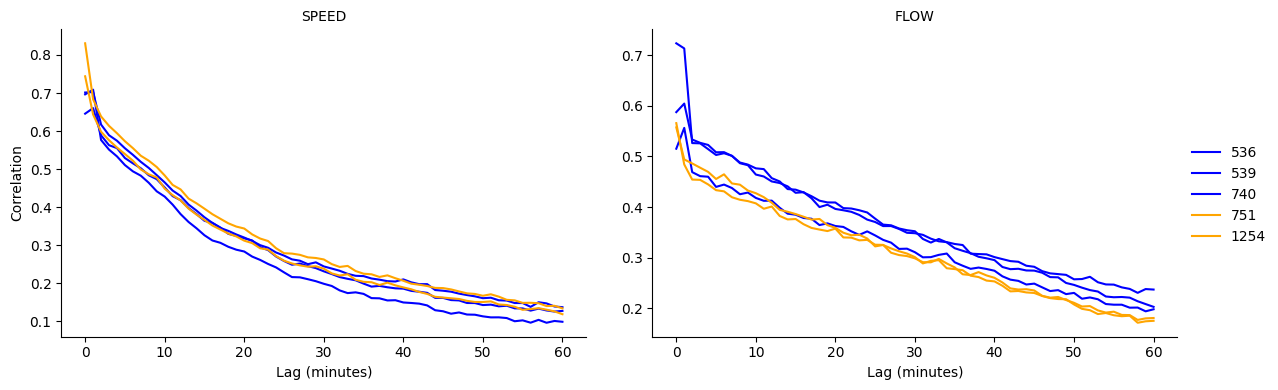

feature  sensor
SPEED    751       0.830716
         1254      0.744050
FLOW     539       0.723636
SPEED    539       0.708879
         740       0.702637
         536       0.660361
FLOW     740       0.604476
         1254      0.565824
         751       0.557476
         536       0.556442
Name: corr, dtype: float64


In [200]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ["SPEED", "FLOW"]
max_lag = 60

results = []

for feat in features:
    target_col = f"SENSOR_{target_sensor}_{feat}" #SENSOR_1076_FLOW
    for sensor in except_target_sensors:
        sensor_col = f"SENSOR_{sensor}_{feat}"
        for lag in range(max_lag + 1):
            corr = df_all_peak[target_col].corr(df_all_peak[sensor_col].shift(lag))
            results.append({
                "feature": feat,
                "sensor": sensor,
                "lag": lag,
                "corr": corr
            })

lag_corr_df = pd.DataFrame(results)

# Plot getrennt nach Feature
#g = sns.FacetGrid(lag_corr_df, col="feature", sharey=False, height=4, aspect=1.5)
#g.map_dataframe(sns.lineplot, x="lag", y="corr", hue="sensor")
#g.add_legend()
#g.set_axis_labels("Lag (minutes)", "Correlation")
#g.set_titles("{col_name}")
#plt.show()

lag_corr_df["portal"] = lag_corr_df["sensor"].map(sensor_to_portal)
portal_colors = {
    "56160": "blue",
    "55620": "orange",
    # weitere Portale nach Bedarf
}



g = sns.FacetGrid(lag_corr_df, col="feature", sharey=False, height=4, aspect=1.5)

def portal_lineplot(data, **kwargs):
    for sensor, group in data.groupby("sensor"):
        portal = sensor_to_portal.get(sensor, "unknown")
        color = portal_colors.get(portal, "gray")
        kwargs_clean = {k: v for k, v in kwargs.items() if k != "color"}
        sns.lineplot(
            data=group,
            x="lag",
            y="corr",
            label=sensor,
            color=color,
            **kwargs_clean
        )

g.map_dataframe(portal_lineplot)
g.add_legend()
g.set_axis_labels("Lag (minutes)", "Correlation")
g.set_titles("{col_name}")
plt.savefig("Plots/Correlation_lag_flow_speed_peak.eps")
plt.savefig("Plots/Correlation_lag_flow_speed_peak.png")
plt.show()


# stärkste Korrelation pro Feature und Sensor
top_sensors = lag_corr_df.groupby(["feature", "sensor"])["corr"].max().sort_values(ascending=False)
print(top_sensors)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1000x500 with 0 Axes>

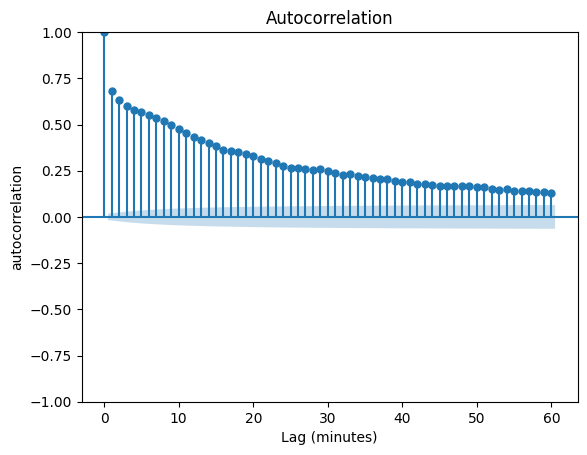

9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1000x500 with 0 Axes>

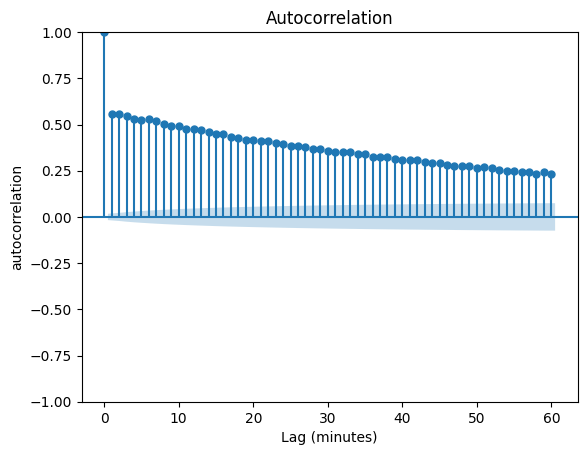

41


In [199]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


plt.figure(figsize=(10,5))
plot_acf(df_all_peak['SENSOR_1076_SPEED'].dropna(), lags=60, alpha=0.05)
plt.xlabel("Lag (minutes)")
plt.ylabel("autocorrelation")
plt.savefig("Plots/Speed/autocorrelation_peak.eps")
plt.show()

acf_values = acf(df_all_peak['SENSOR_1076_SPEED'].dropna(), nlags=60)

lag_threshold = np.argmax(acf_values < 0.5)

print(lag_threshold)

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


plt.figure(figsize=(10,5))
plot_acf(df_all_peak['SENSOR_1076_FLOW'].dropna(), lags=60, alpha=0.05)
plt.xlabel("Lag (minutes)")
plt.ylabel("autocorrelation")
plt.savefig("Plots/Flow/autocorrelation_peak.eps")
plt.show()

acf_values = acf(df_all['SENSOR_1076_FLOW'].dropna(), nlags=60)

lag_threshold = np.argmax(acf_values < 0.5)

print(lag_threshold)

In [197]:
selected_lags = lag_corr_df[lag_corr_df["corr"] >= 0.7 * lag_corr_df.groupby(["feature", "sensor"])["corr"].transform("max")]
print(selected_lags)
print(selected_lags.groupby(["feature", "sensor"])["lag"].max())
print(selected_lags.groupby(["feature", "sensor"])["lag"].max().groupby(["feature"]).mean())


    feature  sensor  lag      corr portal
0     SPEED     539    0  0.696572  56160
1     SPEED     539    1  0.708879  56160
2     SPEED     539    2  0.576724  56160
3     SPEED     539    3  0.551420  56160
4     SPEED     539    4  0.533617  56160
..      ...     ...  ...       ...    ...
557    FLOW    1254    8  0.414330  55620
558    FLOW    1254    9  0.411669  55620
559    FLOW    1254   10  0.407242  55620
560    FLOW    1254   11  0.396553  55620
561    FLOW    1254   12  0.401022  55620

[101 rows x 5 columns]
feature  sensor
FLOW     536       13
         539        4
         740       16
         751       14
         1254      12
SPEED    536        9
         539        5
         740        8
         751        4
         1254       6
Name: lag, dtype: int64
feature
FLOW     11.8
SPEED     6.4
Name: lag, dtype: float64


In [119]:
#nlags=30
nlags=15

In [151]:
def build_lag_features(df, target_col, lags=nlags):
    df = df.sort_values('Datetime')
    for i in range(1, lags + 1):
        df[f'{target_col}_lag_{i}'] = df.groupby('DP_ID')[target_col].shift(i)
    return df


In [152]:
df_lagged = build_lag_features(df_2_full, 'FLOW_filled', lags=nlags)
df_lagged = build_lag_features(df_lagged,"SPEED_MS_AVG_filled", lags=nlags)
df_lagged = df_lagged[df_lagged[f'FLOW_filled_lag_{nlags}'].notna()]
#decay_weights = np.exp(-np.linspace(0, 2, 15))  # z. B. λ=2
#df_lagged['FLOW_decay_feature'] = sum(
#    df_lagged[f'FLOW_filled_lag_{i+1}'] * decay_weights[i]
#    for i in range(15)
#)
print(df_lagged.isna().sum())
print(df_lagged.shape)


Datetime                          0
DP_ID                             0
PORTAL                            0
Interval_1                        0
Interval_5                        0
Interval_15                       0
Interval_30                       0
Interval_60                       0
SPEED_MS_AVG                  22876
FLOW                          22876
Time_only                         0
Date_only                         0
PORTAL_clean                      0
SPEED_MS_AVG_filled               0
FLOW_filled                       0
FLOW_future_sum                  84
SPEED_future_mean                84
FLOW_filled_lag_1                 0
FLOW_filled_lag_2                 0
FLOW_filled_lag_3                 0
FLOW_filled_lag_4                 0
FLOW_filled_lag_5                 0
FLOW_filled_lag_6                 0
FLOW_filled_lag_7                 0
FLOW_filled_lag_8                 0
FLOW_filled_lag_9                 0
FLOW_filled_lag_10                0
FLOW_filled_lag_11          

In [153]:
df_lagged_all = []
for sensor in except_target_sensors:
    df_sensor = df_lagged[df_lagged['DP_ID'] == sensor].copy()
    df_sensor = df_sensor.rename(columns={
        f'FLOW_filled_lag_{i+1}': f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)
    })
    df_sensor = df_sensor.rename(columns={
        f'SPEED_MS_AVG_filled_lag_{i+1}': f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)
    })
    df_sensor = df_sensor[['Datetime'] + [f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)]+[f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)]]
    df_lagged_all.append(df_sensor)
df_lagged_all = reduce(lambda l, r: pd.merge(l, r, on='Datetime', how='inner'), df_lagged_all)
df_lagged_all=df_lagged_all.merge(df_2_full[df_2_full['DP_ID']==target_sensor][["Datetime","FLOW_filled","SPEED_MS_AVG_filled"]], on=['Datetime'], how='left')
#df_lagged_all = df_lagged_all.rename(columns={f'FLOW_filled': f'SENSOR_{target_sensor}_FLOW_filled'})
df_lagged_all.head()
print(df_lagged_all.columns)

Index(['Datetime', 'SENSOR_539_FLOW_lag_1', 'SENSOR_539_FLOW_lag_2',
       'SENSOR_539_FLOW_lag_3', 'SENSOR_539_FLOW_lag_4',
       'SENSOR_539_FLOW_lag_5', 'SENSOR_539_FLOW_lag_6',
       'SENSOR_539_FLOW_lag_7', 'SENSOR_539_FLOW_lag_8',
       'SENSOR_539_FLOW_lag_9',
       ...
       'SENSOR_1254_SPEED_lag_8', 'SENSOR_1254_SPEED_lag_9',
       'SENSOR_1254_SPEED_lag_10', 'SENSOR_1254_SPEED_lag_11',
       'SENSOR_1254_SPEED_lag_12', 'SENSOR_1254_SPEED_lag_13',
       'SENSOR_1254_SPEED_lag_14', 'SENSOR_1254_SPEED_lag_15', 'FLOW_filled',
       'SPEED_MS_AVG_filled'],
      dtype='object', length=153)


In [219]:
flow_features_same = [
    f'SENSOR_{sensor}_FLOW_lag_{i+1}'
    for sensor in same_sensors
    for i in range(nlags)
]
flow_features_neighbour = [
    f'SENSOR_{sensor}_FLOW_lag_{i+1}'
    for sensor in neighbour_sensors
    for i in range(nlags)
]
speed_features_same = [
    f'SENSOR_{sensor}_SPEED_lag_{i+1}'
    for sensor in same_sensors
    for i in range(nlags)
]
speed_features_neighbour = [
    f'SENSOR_{sensor}_SPEED_lag_{i+1}'
    for sensor in neighbour_sensors
    for i in range(nlags)
]

In [183]:
df_lagged_all_peak= df_lagged_all.set_index("Datetime").between_time("07:30", "08:30").reset_index()
df_lagged_all_peak.head()

,Datetime,SENSOR_539_FLOW_lag_1,SENSOR_539_FLOW_lag_2,SENSOR_539_FLOW_lag_3,SENSOR_539_FLOW_lag_4,SENSOR_539_FLOW_lag_5,SENSOR_539_FLOW_lag_6,SENSOR_539_FLOW_lag_7,SENSOR_539_FLOW_lag_8,SENSOR_539_FLOW_lag_9,...,SENSOR_1254_SPEED_lag_10,SENSOR_1254_SPEED_lag_11,SENSOR_1254_SPEED_lag_12,SENSOR_1254_SPEED_lag_13,SENSOR_1254_SPEED_lag_14,SENSOR_1254_SPEED_lag_15,FLOW_filled,SPEED_MS_AVG_filled,FLOW_future_sum,SPEED_future_mean
0,2021-06-01 07:30:00,17.0,11.0,18.0,13.0,20.0,13.0,18.0,10.0,17.0,...,22.30,22.35,22.30,23.17,23.56,24.36,16.0,18.95,304.0,18.292000
1,2021-06-01 07:31:00,12.0,17.0,11.0,18.0,13.0,20.0,13.0,18.0,10.0,...,22.27,22.30,22.35,22.30,23.17,23.56,20.0,18.36,311.0,18.148667
2,2021-06-01 07:32:00,17.0,12.0,17.0,11.0,18.0,13.0,20.0,13.0,18.0,...,23.91,22.27,22.30,22.35,22.30,23.17,19.0,18.53,309.0,18.065333
3,2021-06-01 07:33:00,12.0,17.0,12.0,17.0,11.0,18.0,13.0,20.0,13.0,...,22.80,23.91,22.27,22.30,22.35,22.30,19.0,19.97,310.0,17.988667
4,2021-06-01 07:34:00,15.0,12.0,17.0,12.0,17.0,11.0,18.0,13.0,20.0,...,22.79,22.80,23.91,22.27,22.30,22.35,17.0,19.69,307.0,17.882000


In [223]:
df_train, df_test = train_test_split(df_lagged_all, test_size=0.2, random_state=42)
df_test_peak=df_test.set_index("Datetime").between_time("07:30", "08:30").reset_index()


In [224]:
#saame portal


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_same], df_train['FLOW_filled'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_same], df_train['SPEED_MS_AVG_filled'])



#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# prediction
y_pred = model_flow.predict(df_test[flow_features_same])
y_test=df_test['FLOW_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Speed-Intercept:", model_speed.intercept_)
print("Speed-Koeffizienten:", model_speed.coef_)
print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_same])
y_test=df_test['SPEED_MS_AVG_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Flow-Intercept:", model_flow.intercept_)

print("Flow-Koeffizienten:", model_flow.coef_)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Speed-Intercept: 2.43243015122108
Speed-Koeffizienten: [ 2.33265016e-01  1.48198572e-01  9.31657269e-02  6.57063815e-02
  6.11735071e-02  4.06977852e-02  2.19257149e-02  2.41694995e-02
  1.13457195e-02  2.79890665e-03 -9.07702956e-04  3.65697340e-03
 -1.23072251e-02  4.40752650e-03 -3.85445843e-04  1.09305751e-01
  2.18098844e-02  1.16505367e-02  5.12290410e-03 -6.63924794e-03
  6.59904545e-04 -5.68804155e-03  7.60558362e-05 -1.69500654e-03
  2.13512177e-03  4.03151209e-03  3.61105390e-03 -6.40021868e-03
 -1.93170158e-03 -8.90646316e-04]
Baseline Linear Regression (FLOW) -> RMSE: 3.865, MAE: 3.001, R2: 0.642
Flow-Intercept: -0.1325294700821047
Flow-Koeffizienten: [ 0.12599021  0.11953484  0.10044394  0.08330801  0.05392379  0.05248376
  0.03686804  0.02880923  0.01817843  0.01614198  0.0100992   0.0171891
  0.00121184  0.01327735  0.01200493  0.0907051   0.03552383  0.02164765
  0.02040404  0.01418753  0.00632759  0.00104458  0.00344631 -0.00146061
  0.00140273  0.00407632  0.00714713 

C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [225]:
y_pred = model_flow.predict(df_test_peak[flow_features_same])
y_test=df_test_peak['FLOW_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Speed-Intercept:", model_speed.intercept_)
print("Speed-Koeffizienten:", model_speed.coef_)
print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test_peak[speed_features_same])
y_test=df_test_peak['SPEED_MS_AVG_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Flow-Intercept:", model_flow.intercept_)

print("Flow-Koeffizienten:", model_flow.coef_)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Speed-Intercept: 2.43243015122108
Speed-Koeffizienten: [ 2.33265016e-01  1.48198572e-01  9.31657269e-02  6.57063815e-02
  6.11735071e-02  4.06977852e-02  2.19257149e-02  2.41694995e-02
  1.13457195e-02  2.79890665e-03 -9.07702956e-04  3.65697340e-03
 -1.23072251e-02  4.40752650e-03 -3.85445843e-04  1.09305751e-01
  2.18098844e-02  1.16505367e-02  5.12290410e-03 -6.63924794e-03
  6.59904545e-04 -5.68804155e-03  7.60558362e-05 -1.69500654e-03
  2.13512177e-03  4.03151209e-03  3.61105390e-03 -6.40021868e-03
 -1.93170158e-03 -8.90646316e-04]
Baseline Linear Regression (FLOW) -> RMSE: 3.937, MAE: 3.143, R2: 0.470
Flow-Intercept: -0.1325294700821047
Flow-Koeffizienten: [ 0.12599021  0.11953484  0.10044394  0.08330801  0.05392379  0.05248376
  0.03686804  0.02880923  0.01817843  0.01614198  0.0100992   0.0171891
  0.00121184  0.01327735  0.01200493  0.0907051   0.03552383  0.02164765
  0.02040404  0.01418753  0.00632759  0.00104458  0.00344631 -0.00146061
  0.00140273  0.00407632  0.00714713 

C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [186]:
#neighbour


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_neighbour], df_train['FLOW_filled'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_neighbour], df_train['SPEED_MS_AVG_filled'])



#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# Vorhersage
y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test=df_test['FLOW_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test=df_test['SPEED_MS_AVG_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.262, MAE: 2.594, R2: 0.621
Baseline Linear Regression (SPEED) -> RMSE: 0.963, MAE: 0.662, R2: 0.473


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Predict total flow /average speed for the next 15 mins

In [161]:
df_2_full['FLOW_future_sum'] = (
    df_2_full.groupby('DP_ID')['FLOW_filled']
    .rolling(15, min_periods=15)
    .sum()
    .shift(-14)  # damit die Summe bei t=07:02 die Werte von 07:02–07:16 enthält
    .reset_index(level=0, drop=True)
)
df_2_full['SPEED_future_mean'] = (
    df_2_full.groupby('DP_ID')['SPEED_MS_AVG_filled']
    .rolling(15, min_periods=15)
    .mean()
    .shift(-14)  # damit die Summe bei t=07:02 die Werte von 07:02–07:16 enthält
    .reset_index(level=0, drop=True)
)


df_lagged_all=df_lagged_all.merge(df_2_full[df_2_full['DP_ID']==target_sensor][["Datetime","FLOW_future_sum","SPEED_future_mean"]], on=['Datetime'], how='left')
print(df_lagged_all.shape)
df_lagged_all = df_lagged_all[df_lagged_all['Datetime'].dt.time <= time(9, 45)]
print(df_lagged_all.shape)

#print(df_lagged_all["Datetime"]dt.time.min(), df_lagged_all["Datetime"].dt.date.max())
df_lagged_all.head(20)
print(df_lagged_all.isna().sum())


(76156, 155)
(72991, 155)
Datetime                    0
SENSOR_539_FLOW_lag_1       0
SENSOR_539_FLOW_lag_2       0
SENSOR_539_FLOW_lag_3       0
SENSOR_539_FLOW_lag_4       0
                           ..
SENSOR_1254_SPEED_lag_15    0
FLOW_filled                 0
SPEED_MS_AVG_filled         0
FLOW_future_sum             0
SPEED_future_mean           0
Length: 155, dtype: int64


In [187]:
df_lagged_all_peak= df_lagged_all.set_index("Datetime").between_time("07:30", "08:30").reset_index()
df_lagged_all_peak.head()

,Datetime,SENSOR_539_FLOW_lag_1,SENSOR_539_FLOW_lag_2,SENSOR_539_FLOW_lag_3,SENSOR_539_FLOW_lag_4,SENSOR_539_FLOW_lag_5,SENSOR_539_FLOW_lag_6,SENSOR_539_FLOW_lag_7,SENSOR_539_FLOW_lag_8,SENSOR_539_FLOW_lag_9,...,SENSOR_1254_SPEED_lag_10,SENSOR_1254_SPEED_lag_11,SENSOR_1254_SPEED_lag_12,SENSOR_1254_SPEED_lag_13,SENSOR_1254_SPEED_lag_14,SENSOR_1254_SPEED_lag_15,FLOW_filled,SPEED_MS_AVG_filled,FLOW_future_sum,SPEED_future_mean
0,2021-06-01 07:30:00,17.0,11.0,18.0,13.0,20.0,13.0,18.0,10.0,17.0,...,22.30,22.35,22.30,23.17,23.56,24.36,16.0,18.95,304.0,18.292000
1,2021-06-01 07:31:00,12.0,17.0,11.0,18.0,13.0,20.0,13.0,18.0,10.0,...,22.27,22.30,22.35,22.30,23.17,23.56,20.0,18.36,311.0,18.148667
2,2021-06-01 07:32:00,17.0,12.0,17.0,11.0,18.0,13.0,20.0,13.0,18.0,...,23.91,22.27,22.30,22.35,22.30,23.17,19.0,18.53,309.0,18.065333
3,2021-06-01 07:33:00,12.0,17.0,12.0,17.0,11.0,18.0,13.0,20.0,13.0,...,22.80,23.91,22.27,22.30,22.35,22.30,19.0,19.97,310.0,17.988667
4,2021-06-01 07:34:00,15.0,12.0,17.0,12.0,17.0,11.0,18.0,13.0,20.0,...,22.79,22.80,23.91,22.27,22.30,22.35,17.0,19.69,307.0,17.882000


In [188]:
df_train, df_test = train_test_split(df_lagged_all_peak, test_size=0.2, random_state=42)

#split_time = df_2_full['Datetime'].quantile(0.8)
#print(split_time)

#df_train = df_lagged_all[df_lagged_all['Datetime'] <= split_time]
#df_test = df_lagged_all[df_lagged_all['Datetime'] > split_time]


In [189]:
#same portal




model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_same], df_train['FLOW_future_sum'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_same], df_train['SPEED_future_mean'])

#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# Vorhersage
y_pred = model_flow.predict(df_test[flow_features_same])
y_test=df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")


y_pred = model_speed.predict(df_test[speed_features_same])
y_test=df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Baseline Linear Regression (FLOW) -> RMSE: 27.954, MAE: 20.725, R2: 0.779
Baseline Linear Regression (SPEED) -> RMSE: 0.604, MAE: 0.356, R2: 0.644


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [190]:
#neighbour portal


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_neighbour], df_train['FLOW_future_sum'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_neighbour], df_train['SPEED_future_mean'])

#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# Vorhersage
y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test=df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")


y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test=df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Baseline Linear Regression (FLOW) -> RMSE: 23.297, MAE: 16.670, R2: 0.846
Baseline Linear Regression (SPEED) -> RMSE: 0.703, MAE: 0.399, R2: 0.518


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGB-Boost

In [191]:


model_flow = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_flow.fit(df_train[flow_features_same], df_train['FLOW_future_sum'])

model_speed = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_speed.fit(df_train[speed_features_same], df_train['SPEED_future_mean'])




y_pred = model_flow.predict(df_test[flow_features_same])
y_test = df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_same])
y_test = df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

XGBoost Regression (FLOW) -> RMSE: 24.344, MAE: 18.394, R²: 0.832
XGBoost Regression (SPEED) -> RMSE: 0.566, MAE: 0.327, R²: 0.687


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [192]:
from xgboost import XGBRegressor
model_flow = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_flow.fit(df_train[flow_features_neighbour], df_train['FLOW_future_sum'])

model_speed = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_speed.fit(df_train[speed_features_neighbour], df_train['SPEED_future_mean'])




y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test = df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test = df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

XGBoost Regression (FLOW) -> RMSE: 20.155, MAE: 15.405, R²: 0.885
XGBoost Regression (SPEED) -> RMSE: 0.635, MAE: 0.331, R²: 0.607


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [203]:
#df_lagged_all.to_parquet("data/processed/df_lagged_all.parquet", index=False)
#df_lagged_all.to_parquet("data/processed/df_lagged_30_all.parquet", index=False)
df_lagged_all_peak.to_parquet("data/processed/df_lagged_all_peak.parquet", index=False)